## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import scipy.stats as stats
from math import ceil

import warnings
warnings.filterwarnings("ignore")

In [2]:
## количество испытуемых, полученное в примере a_b_test_inference.csv

effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [19]:
df = pd.read_csv('./ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [4]:
## функции взяты из примера a_b_test_inference.csv
# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

In [5]:
## проверка на дубликаты, взятая из примера a_b_test_inference.csv
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [6]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def show_exp_results(ab_df):
    """
        Выполняет оценку значимости разницы между двумя группами испытуемых 
        (пункт 4. 'Тестирование гипотезы' из примера a_b_test_inference.csv)
    """
    control_results = ab_df[ab_df['group'] == 'control']['converted']
    treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    print(f'Z-statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

In [7]:
def perform_exp(df):
    """
        Выполняет извлечение случайным образом required_n пользователей для каждой группы испытуемых
        (пункт 2. 'Сбор данных и их подготовка' из примера a_b_test_inference.csv)
    """
    control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
    treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)

    # Сформируем общую случайную выборку
    ab_df = pd.concat([control_sample, treatment_sample], axis=0)
    ab_df.reset_index(drop=True, inplace=True)
    return ab_df

**Вопрос 1 (вариант работы сервиса - standard или svm_ensemble_v_1_22)**

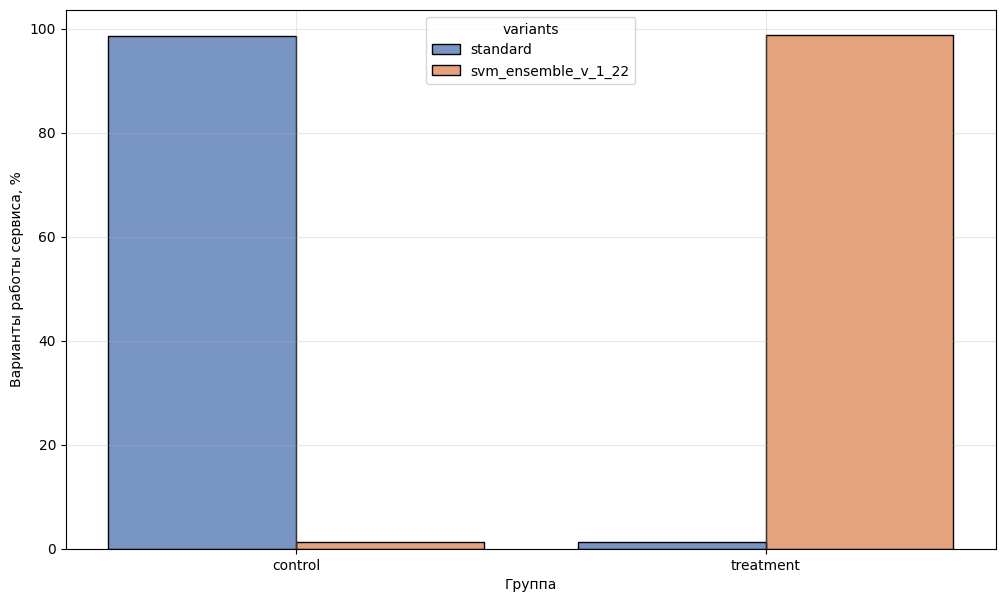

In [25]:
import seaborn as sns

plt.figure(figsize=(12, 7))

ax = sns.histplot(data=df, 
             x='group', 
             hue='variants',  
             multiple='dodge', 
             palette='deep',
             shrink=0.8,
             stat='percent',
             common_norm=False)
sns.move_legend(ax, "upper center")

plt.xlabel('Группа')
plt.ylabel('Варианты работы сервиса, %')
plt.grid(True, alpha=0.3)
plt.show();

Можно наблюдать дисбаланс по вариантам работы сервиса. \
В контрольной группе перекос в сторону старого варианта работы 'standard', в тестовой группе перекос в сторону нового варианта работы 'svm_ensemble_v_1_22' 

In [9]:
# выполняем один эксперимент для всей выборки (294478 записей)
ab_df = perform_exp(df)

In [10]:
standard_var_ab_df = ab_df[ab_df['variants'] == 'standard']
# оценим результаты эксперимента для варианта работы сервиса 'standard'
show_exp_results(standard_var_ab_df)

Z-statistic: 0.04
p-value: 0.968
CI 95% for control group: [0.122, 0.142]
CI 95% for treatment group: [0.051, 0.210]


p-значение = 0.968 выше уровня значимости 0.05, поэтому не можем отклонить нулевую гипотезу H0.\
Доверительный интервал [0.05, 0.21] включает baseline (13 %) и достигает цели (15%). \
Можно трактовать, что эффект слишком мал или у нас недостаточно данных.

In [11]:
svm_var_ab_df = ab_df[ab_df['variants'] == 'svm_ensemble_v_1_22']
# оценим результаты эксперимента для варианта работы сервиса 'svm_ensemble_v_1_22'
show_exp_results(svm_var_ab_df)

Z-statistic: 0.94
p-value: 0.345
CI 95% for control group: [0.068, 0.249]
CI 95% for treatment group: [0.110, 0.129]


p-значение = 0.345 выше уровня значимости 0.05, поэтому не можем отклонить нулевую гипотезу H0.\
Доверительный интервал [0.11, 0.13] включает baseline (13 %) и не достигает цели (15%). \
Можно трактовать, что эффект незначим и при больших данных гипотеза H1, скорее всего, не сработает на нужном уровне.

Таким образом, 
1) эффект для нового варианта работы 'svm_ensemble_v_1_22' незначим;
2) эффект для старого варианта работы 'standard' слишком мал. Возможно, увеличение выборки даст нужный эффект.
   
Лучше оставить старый вариант работы сервиса 'standard'

**Вопрос 2 (вариант работы сервиса - standard или svm_ensemble_v_1_22 по группам пользователей)**

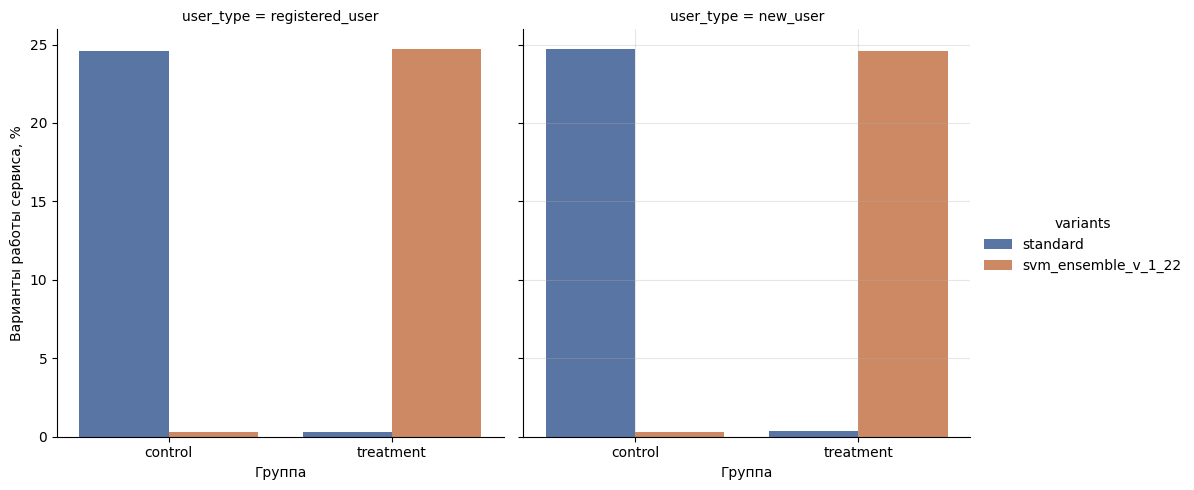

In [23]:
ax = sns.catplot(data=df,
            kind='count',
            x='group',
            col='user_type',
            hue='variants',
            palette='deep',
            stat='percent');

ax.set_axis_labels(x_var='Группа', y_var='Варианты работы сервиса, %')
plt.grid(True, alpha=0.3)
plt.show();

Можно наблюдать дисбаланс по вариантам работы сервиса между контрольной и тестовой группой. \
При этом распределения по типам пользователей сопоставимы.

In [13]:
new_user_df = df[df['user_type'] == 'new_user']
# выполняем первый эксперимент для новый пользователей (147238 записей)
new_user_ab_df = perform_exp(new_user_df)

In [14]:
new_user_standard_var_ab_df = new_user_ab_df[new_user_ab_df['variants'] == 'standard']
# оценим результаты эксперимента для варианта работы сервиса 'standard' и новых пользователей
show_exp_results(new_user_standard_var_ab_df)

Z-statistic: -1.65
p-value: 0.100
CI 95% for control group: [0.113, 0.131]
CI 95% for treatment group: [0.094, 0.287]


p-значение = 0.10 выше уровня значимости 0.05, поэтому не можем отклонить нулевую гипотезу H0.\
Доверительный интервал [0.09, 0.29] включает baseline (13 %) и достигает цели (15%). \
Можно трактовать, что эффект слишком мал или у нас недостаточно данных.

In [15]:
new_user_svm_var_ab_df = new_user_ab_df[new_user_ab_df['variants'] == 'svm_ensemble_v_1_22']
# оценим результаты эксперимента для варианта работы сервиса 'svm_ensemble_v_1_22' и новых пользователей
show_exp_results(new_user_svm_var_ab_df)

Z-statistic: 0.02
p-value: 0.986
CI 95% for control group: [0.039, 0.215]
CI 95% for treatment group: [0.117, 0.136]


p-значение = 0.986 выше уровня значимости 0.05, поэтому не можем отклонить нулевую гипотезу H0.\
Доверительный интервал [0.12, 0.14] включает baseline (13 %) и не достигает цели (15%). \
Можно трактовать, что эффект незначим и при больших данных гипотеза H1, скорее всего, не сработает на нужном уровне.

In [16]:
reg_user_df = df[df['user_type'] == 'registered_user']
# выполняем второй эксперимент для старых пользователей (147240 записей)
reg_user_ab_df = perform_exp(reg_user_df)

In [17]:
 reg_user_standard_var_ab_df = reg_user_ab_df[reg_user_ab_df['variants'] == 'standard']
# оценим результаты эксперимента для варианта работы сервиса 'standard' и старых пользователей
show_exp_results(reg_user_standard_var_ab_df)

Z-statistic: -0.24
p-value: 0.808
CI 95% for control group: [0.112, 0.131]
CI 95% for treatment group: [0.041, 0.223]


p-значение = 0.808 выше уровня значимости 0.05, поэтому не можем отклонить нулевую гипотезу H0.\
Доверительный интервал [0.04, 0.22] включает baseline (13 %) и достигает цели (15%).\
Можно трактовать, что эффект слишком мал или у нас недостаточно данных.


In [18]:
reg_user_svm_var_ab_df = reg_user_ab_df[reg_user_ab_df['variants'] == 'svm_ensemble_v_1_22']
# оценим результаты эксперимента для варианта работы сервиса 'svm_ensemble_v_1_22' и старых пользователей
show_exp_results(reg_user_svm_var_ab_df)

Z-statistic: 0.53
p-value: 0.598
CI 95% for control group: [0.055, 0.226]
CI 95% for treatment group: [0.110, 0.128]


p-значение = 0.598 выше уровня значимости 0.05, поэтому не можем отклонить нулевую гипотезу H0.\
Доверительный интервал [0.11, 0.13] включает baseline (13 %) и не достигает цели (15%). \
Можно трактовать, что эффект незначим и при больших данных гипотеза H1, скорее всего, не сработает на нужном уровне.

Таким образом, 
1) эффект для нового варианта работы 'svm_ensemble_v_1_22' для старых и новых пользователей незначим;
2) эффект для старого варианта работы 'standard' для старых и новых пользователей слишком мал. Возможно, увеличение выборки даст нужный эффект.
   
Лучше оставить старый вариант работы сервиса 'standard' для старых и новых пользователей.   